Author: Mark Searle  
Contact: bg223@stud.uni-heidelberg.de

# PyHelios Demo: Live LiDAR simulation trajectory plot.

***

This notebook demos the excecution of a __LiDAR survey simulation__ using integrated Python functionalities to initiate __HELIOS++__.
The trajectory of the virtual scanner which can be configured to sit upon different moving or stationary platforms is plotted __live__ using __matplotlib__.

***
The survey is configured through a __.xml survey file__ containing survey name, platform type, scanner type, and scene to be scanned along with platform and scanner settings.  
The simulation runs in several legs which represent individual scanner trajectories and are also configured from within survey file.

__The survey files are located within 'helios/data/surveys'!__

The __survey used in this demo__ (`custom_als_toyblocks.xml`) should be located in this survey folder.

***

In [1]:
# Imports
import time
import os
import sys
import numpy as np
from pathlib import Path

# Magic command to enable interactive plots. Is necessary for live updating of trajectory.
%matplotlib notebook

In [2]:
# Change working directory to helios path and configure runpath within pyhelios.
helios_path = str(Path.cwd().parent)
sys.path.append(helios_path)

helios_run_path = 'run/'
# Survey to be used.
survey_path = 'toyblocks/custom_als_toyblocks.xml'

# Change working directory.
os.chdir(helios_path)

In [3]:
# PyHelios import
import pyhelios

__NOTE:__ Changing working directory to helios path only necessary when running notebook from outside helios path. Run path must be added before importing pyhelios, unless permanent .pth solution applied.

## Live Trajectory Plot of LiDAR Simulation with PyHelios

***

1. Define Callback function to continuously extract values from simulation:

In [4]:
# Empty list for trajectory values.
tpoints = []

In [5]:
# Callback frequency is defined through parameter simFrequency which is set once the simulation is built.
def callback(output=None):
    global tpoints
    
    # Store trajectories in variable.
    trajectories = output.trajectories
    # Add current values to list
    try: 
        tpoints.append([trajectories[len(trajectories) - 1].getPosition().x,
                    trajectories[len(trajectories) - 1].getPosition().y,
                    trajectories[len(trajectories) - 1].getPosition().z])
        
    # At the beginning of each new simulation leg, trajectories can have the length 0.
    # When indexing with [0 - 1] an indexing issue can occurr that is caught in this block.
    except Exception as err:
        #print('An Error occurred:', err)
        pass

1. Configure simulation context and build a simulation:

In [6]:
# Sim context.
# Set logging.
pyhelios.loggingVerbose2()
# Set seed for random number generator.
pyhelios.setDefaultRandomnessGeneratorSeed("123")

In [7]:
# Build simulation parameters: (surveyPath, assetsPath, outputPath, ...).
from pyhelios import outputToNumpy, SimulationBuilder

simB = SimulationBuilder('data/surveys/' + survey_path, "assets/", "output/")
simB.setLasOutput(True)
simB.setZipOutput(False)
simB.setSimFrequency(10000)
simB.setFinalOutput(True)
simB.setCallback(callback)


2. Load survey file:

In [8]:
sim = simB.build()

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 0.02498210000000034 seconds


3. Create ground plane object for more comprehensive visualization:

In [9]:
# Empty list for groundplane vals.
groundplane_list = []

# List filled every 25th value from (-75, -75, 0) to (75, 75, 0).
for i in range(-75, 76, 25):
    for j in range(-75, 76, 25):
        groundplane_list.append([i, j, 0])
        
# List converted to numpy Array.
groundplane = np.array(groundplane_list)

4. Define function __update_3dline__ that adds values to a line object and plots them onto a matplotlib figure from a continuously updating list.

In [10]:
def update_3dline(dynamic_list,  line_obj, figure, refresh_rate=0.5):
    '''Continuously updates matplotlib line with values from a steadily growing list.
     The function terminates when no new values are added to the list within the specified refresh rate.
    
    Parameters:
    dynamic_list (list): A list of xyz points that is continuously growing in the background (format: [[x, y, z], [x, y, z], ...])
    line_obj (matplotlib.axes.Axes.plot): An empty line with 3 dimensions. E.g.: l, = ax.plot([], [], [])
    figure (matplotlib.pyplot.figure): The figure which contains the axis used to the create line object.
    
    Optional:
    refresh_rate (float, default=0.5): Determines time interval in seconds between each iteration of function.
    '''
    loop_stopper = 0
    while True:
        time.sleep(float(refresh_rate))
        
        # Check whether list contains more new values.
        if loop_stopper != len(dynamic_list):
            
            # Convert x, y, z list to array.
            a = np.array(dynamic_list)
            
            # Update values of line with data from array.
            line1.set_xdata(a[:,0])
            line1.set_ydata(a[:,1])
            line1.set_3d_properties(zs=a[:,2])
            
            # Draw results onto figure.
            fig.canvas.draw()
        else:
            break
            
        # Variable used to check for updates to list.
        loop_stopper = len(dynamic_list)

4. Initiate matplotlib figure and run simulation. Function from previous cell used to update line.

<IPython.core.display.Javascript object>


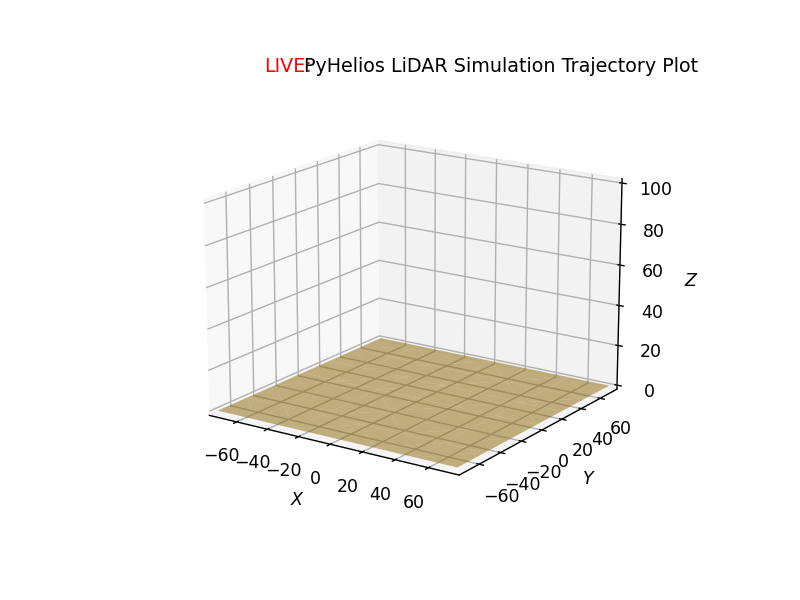

In [11]:
# Imports
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D, art3d
import numpy as np

# Matplotlib figure.
fig = plt.figure()

# Axes3d axis onto mpl figure.
ax = fig.add_subplot(111, projection='3d')

# Set axis extent.
ax.set_xlim([-75,75])
ax.set_ylim([-75,75])
ax.set_zlim([0, 100])

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

# Set title.
ax.text2D(0.185, 1, "LIVE:", fontsize='11', transform=ax.transAxes, c='r')
ax.text2D(0.27, 1, 'PyHelios LiDAR Simulation Trajectory Plot', fontsize='11', transform=ax.transAxes)

# Alternate plain title and subtitle:
#ax.set_title(label='LiDAR Scanner Trajectory from PyHelios Simulation')
#ax.text2D(0.1, 0.97, "survey: {s}, points in trajectory: {n}".format(s=sim.getSurvey().name, n=len(trajectories)),
#                                                                              fontsize='8', transform=ax.transAxes)

# Plot groundplane onto figure.
ax.plot_trisurf(groundplane[:,0], groundplane[:,1], groundplane[:,2], color='darkgoldenrod', label='groundplane', alpha=0.5)

# Update canvas.
fig.canvas.draw()

# Start the simulation.
sim.start()

time.sleep(1)

# Create empty line object.
line1, = ax.plot([], [], [])

# Run function to plot trajectory while simulation is running.
update_3dline(tpoints, line1, fig)